In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, kstest, norm, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Non-spatial Dispersal Coverage Test

In [3]:
def test_nonspatial_dispersal_coverage(
    algorithm, speciation=0.001, seeds=[42], size=100, sample=1.0
):
    total_pvalues = []
    total_locations = []
    
    for seed in tqdm(seeds):
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        locations = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                locations.append((int(row[3]), int(row[4]), int(row[5])))
        locations = np.array(locations)

        # Calculate the goodness of fit of the dispersal coverage
        gof = chisquare(np.histogramdd(locations, bins=(
            range(0, size+1), range(0, size+1), range(0, size+1)
        ))[0].flatten())
        
        total_pvalues.append(gof.pvalue)
        total_locations.append(locations)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Dispersal Histograms:"))
    
    locations = np.concatenate(total_locations)
    
    # Draw the 1d and 2d dispersal coverage histograms
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))
    
    ax1.set_title("Dispersal histogram x")
    ax1.set_xlabel("x")
    ax1.set_ylabel("pmf")
    ax1.hist(locations[:,0], bins=range(0, size+1), density=True)
    
    ax2.set_title("Dispersal histogram y")
    ax2.set_xlabel("y")
    ax2.set_ylabel("pmf")
    ax2.hist(locations[:,1], bins=range(0, size+1), density=True)
    
    ax3.set_title("Dispersal histogram index")
    ax3.set_xlabel("index")
    ax3.set_ylabel("pmf")
    ax3.hist(locations[:,2], bins=range(0, size+1), density=True)

    ax4.set_title("Dispersal histogram x-y")
    ax4.set_xlabel("x")
    ax4.set_ylabel("y")
    hist1 = ax4.hist2d(locations[:,0], locations[:,1],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist1[3], ax=ax4)

    ax5.set_title("Dispersal histogram x-index")
    ax5.set_xlabel("x")
    ax5.set_ylabel("index")
    hist2 = ax5.hist2d(locations[:,0], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist2[3], ax=ax5)

    ax6.set_title("Dispersal histogram y-index")
    ax6.set_xlabel("y")
    ax6.set_ylabel("index")
    hist3 = ax6.hist2d(locations[:,1], locations[:,2],
                       bins=(range(0, size+1), range(0, size+1)),
                       density=True)
    fig.colorbar(hist3[3], ax=ax6)

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

100%|██████████| 1000/1000 [26:23<00:00,  1.58s/it]


## <span style='color:red'><u>Classical</u></span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.9661913662478324
* statistic: 1885.9872588894555

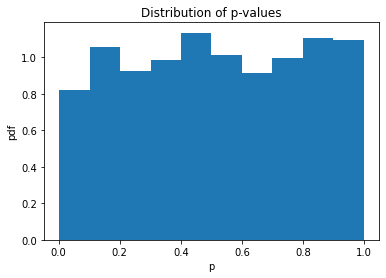

#### Dispersal Histograms:

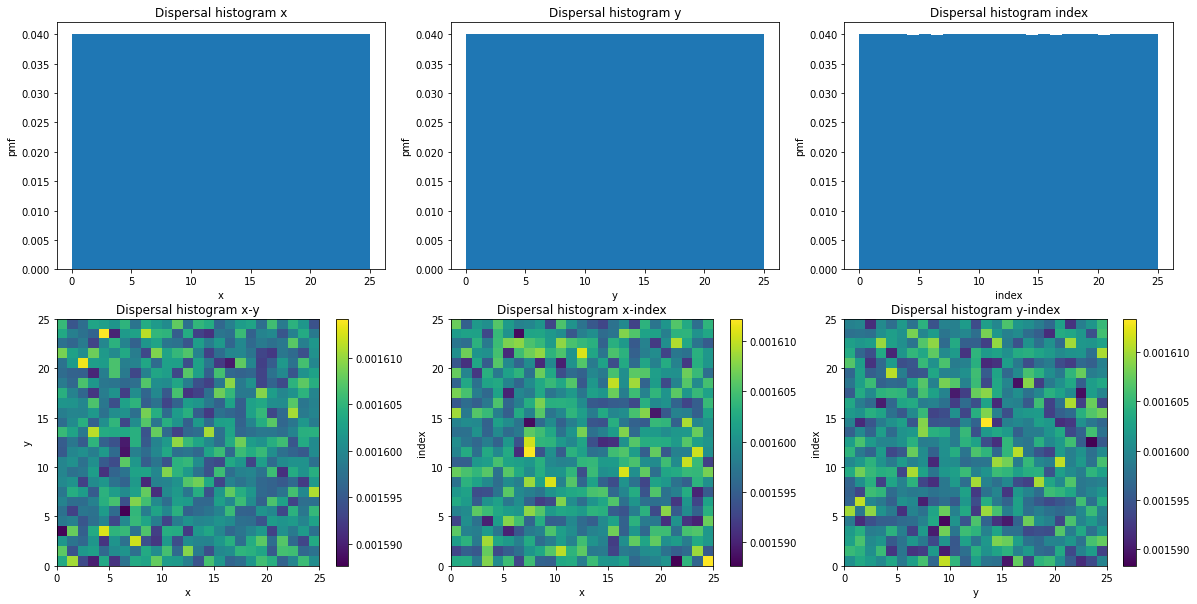

#### Parameters:
* seeds: [14643134819984765391  1266384381303967161 13675280585103076854
 17100680324541749135 12730492551004555255 14753637550801662884
 12115280636367562999  2119116603893314559  6377384616332654223
  6187369618264941842 10441923593305154410  2529549976369649036
 18058399466335685543 10423607690774644658 16477045820847919820
  8956155070934738053 13171270343050687324  1845139403176625208
 11689086747965608509  4627806654355204683 11933559436779638359
  4811248354386103132 14745414878637368873  2031391133673043559
 13863915096259604230  2405142847324042423 15826530675913854646
  9106285521768084494 13416833113812935727  4254768116870405330
 11315502234383646978 13050988414017568874  6263844728022152981
 12988992383621490358 13377642535329896067  4087574370018451321
 12908328592693100452  6155166528646617262 13632539964897211845
  6117668101872455492  7822135033663771714  1913306379876825744
 12236273345240616417 11977471412785217911 15539093873076572808
 15008743819091360761   257759001423754959 15763420441081172371
  9564138915890987486 14902592705774600741 13075760679061117347
 18032777199392620389 17981587847807052805   804415820001835739
  9459579371160505143  8841259639372998495  3956716449715998857
 13414357040226296447  7025388529354252570 17677599019390691470
  1969309339699832691  8230897789569419697 14547635689722816477
 14901105735119015053  1378596991284724148  6239297410480825454
  1207042040129198965  3071755420840669883 13908404823825636469
 10748256509170283858 16602191933558149837  6271034458126129418
 17685672503643326383  2816078632922699877 15408126199072945924
 15702677312220119858  5542915492297986537 18243704003593316071
 13965937696154924525 10349652499450143274  1380207487103623721
  8684329123996078579 11423193238415400838 16130272445109997552
  1551828000608149523  6285089795792227416   428225037189850108
 11952865002903670910 17653416852075582355 17022472728082823135
 12074532886556427883  6958026099209529688 12537497564546977718
  3771835898222446243 11358892693025244323   698024438948796274
  3870464593358626942 17568889845819772870  3909076646130356390
 12912325312471056432  8422177622072964522   625268010904632089
 10726004249420056760 14034911093120080150 11834148856547042239
 18278768146938402854   360482073816954344 14901099817873322647
  1777567227060149416 13420563940150355020  3573913071526097727
  8209216157344259948  1091307970602655577   254766450626967514
  1221730814321283867 14373030159247300778   591839111513995811
 14059909542807886861 15470829319469858359 13091614391473401587
  3357825786636390258 17773099253511552980 11596961140347829117
 17108229255880523315  5106134171405908344   288714794375545864
 14368495924955500031 12152089924037456005  4987939260826309553
  7702290579467865883  2567481207737932184 16202167840608626567
 12578805958970622804 12416771078848756329  2451669584330300197
  9714110027701163733 17422224436958019310  6177251006848462357
 15889683712429217034 17640172749592865649  7362974813404852667
 11213649602952625983  3199729362266080526  2027915700910545648
   307716395776886596  4498766537208714470  6938321420793426771
   792779297227806137 18209865267300842677 18085257306544790698
  8287562794959197581 11340702988368376877 17701091627595052705
 12387972431373531170  5835517433868827863 10516042109197128831
 14549707295344565378 11305810687206560329  5593441484249938390
  4186181123154480108  8776582815315574533  1899627306422429610
  4225644524682643284 14861470013263837261 15909828630796632802
 17893543079635976817  5435121309854631516  3440035578695071453
 12819376146748269846  4474364519906034004  8847908584872494356
   919197005348596391  2697638855133492553  2402108805613719893
  1397577641659162325   461370698011209893 11592432253220796650
  9931896948652812909  3389165854798614641 11332248132027987841
    21473103538439047 13110695276809360055 10883968637145722201
  6059365376484124210  3247308125395759414  6759794748983492244
  2850006639385706946  3452799400309904191 15752832079124696668
  3638859925197951169  8218112622440528353 16077827780577842871
 16236802123259709286  3696555120288654809 17275528823632576971
 10495041204108141990 10722399380763250880  2332732061110556302
 14185522560428203629  7430101514391474597  3810426285327912324
 13571569144116988894 15044509673751998683 14552291569770386129
   693174569699331975 17614080529620242829 13037051431721190923
  6712825581761866206  7540184981264865513  6204046731803550713
   637144320042689877 12847678150607097019 17025685136192889651
 17228139234257038893   651345530037220757  5373491187323952244
   509576245270273251  5522743355150357685  8675585636429646804
  6084089275717001927  7336287379543330305  3950161120554810650
  3510702638942010851 13144286128850837661 13365041660908800209
 17607793123431731800  4819582311820353908 15162750505904139451
 14070534900325261552   155281690643758190  6914257136357806837
 10778001054747448615 10408749101914145150 11641233566032211056
  8339424220278219624 11281146061913003637 13849569158677541889
  5046958528799784251  7740753026511797941 11735975026718899196
  6534556212818716240  5768125206946278708  1659693102894662754
  6251321656804294174  6738451770885163766  4208003786946837661
 10149762702091616211 11734608103906116758 13493564405262413071
 12536456568921891305 12310066565619020009  9101787445894687123
 13010441104582355524 11898385709525738345  1760497877586272132
  3849845007568654604 15649407376031523631 12459851751195609959
 17538089569901891349 15667455352196676634  6966975609152125273
  9163484099850682583  1678706728481003725 13802905795771549088
 12803517512996043552  4052292109946147380  2112706463421127575
  5574083523148644738 16367414318346100147 17181786469466438013
 10745562961171643517  3006085639747992125  6668634763193058770
  8913614943640959578  9374155527868038210  8314604172740385368
 11927164769098176617  1117007270469443475  7310156609622352575
 11652594112984722873  1710780768310964800  1794082541935955107
 12257627041889345275 17350737504305608432 17866705033446312355
  9725809488400816430 17270901139811637795  4085518985171858284
 10191782756464531307  1448911122865882615  7365134912933098347
   815048107206637537 16439899915454445945 14867941572380899367
 10040447710190289805  9583724725063013776 11387490496956493746
 17922387075588123809 11808037743695518684  8437273108413967143
 13386938502598256656  2790080174499483720 15940336700913651216
  1919371475421195485  7337619282761395381  6751693416893071405
  2020559618329593828 11876458237413342037 17611325776592877655
 12180099544114426926  8889018115550770897  4390691063651287194
 16186284126811706491  4319367670152797474  5348995228357975029
  7462980154177591705  8401365850249735527 16370247645607824413
   834490099191743050 17370135476757143228 11873147963671096916
 12198553567682904244 12211696844880316957 15985243946735202907
  1649293470394051909 11127148364628456808 14753291614481867808
 13505890138317275873 14996654200705329478 14519353766464084225
 15006097969437901095  6461259614784950526 10678379849186503832
  7649010144657155805   120465340772343813 15044680904653697038
  2870869426856740714  6322096189049862738  2605040635358750370
  9293730906483019659  2834995854957895068 10224059868566258924
   255948197171941640  9197015568735295380 12726517493561679421
  2268303670264693820  2508453841488545272 17147626729408334468
  6413718968452869828  7675970289330391039 17407701518560342588
 15039533738580038485  1197004457967755794  7716580461984235115
   550751749672840979 18373864832520452023  9182065810974847738
 11198385639254210273 12116888915107899263 16521375382520677459
   835002904655373076  4649143951061823305  3241867324851136871
  2162482429383436407  1304824418864169627 18373925852422892328
  1248022586857312943  8672681726395978390 14656869911967502236
  1259979747886889561  2591653466236891992 15219189489095460788
  2961896760608112987  3472952105483430625 17531948812632982312
  2880003919354992954  4781139405866398507  7660613015650042412
  2890325699293910691 13059534229371524081 18150482193347635795
  3809733912992019834 12204847580600283949  1120341102397027372
  4179134753730926619  4658971745762939597 14693676936419633536
 15688905163725814928 13520433005513698907 14937180522685686519
 11574587559773764444   665471686153480814  3639256425332499311
 13756550902040074699  8994697347748063760     4592979668595108
 17912186828996702870  4609608619717710238 17091838146818297902
  2677612644854233732 17810643905385204616  8149810098826329664
  5997623377765253725   253119883991967267 12880793740646861443
 14752141689097590735  6586121001944014875   536777460347747845
  1918036144363036085 15212667602910962266  2846011892520300457
 15675273861709870107 10833982926751937213  5356693267967794239
 10793972897793060350  3685270783204473171  8506456039604418822
   794914081794715672 14107549510099634396  6141192927539785199
  8862120817112757997  2771761164521045056  8266484104275311516
 12552125335779878950  8998863672641232099  6584375584245829478
 17081470473092558650  4086116294643351325 15559164081851783683
  9228300181490116982  4873833665713585732  7251287850980954673
  1006749950366688435 14376267039774712485   167998370042563904
 10612451863584839198 10399571088928904089  2575092187612362220
  5754344937912176210 11286366735208009939  9274051791973292148
  6069558849842627451 12432572621823912434   761654710313801740
  1053125709590333758 18319267187808078247 13815277207251664668
 13345776328057556552  7146666349095526429   293051235934281985
  7839281638691743044  3611949443153977302  1651201622740658227
  5973045163222011483 13188867817218645064  2814811550419745097
   499881414972823920  1788720327156647664  3280316396841399931
 16319467334893190034  6154759943384467935   196791294908057347
 14497351716069206434  3444360052821909413 17101480481612770630
  6891895475059980690  4946783307516556965 10352834995295461365
 17723026114520518933  1049792486208353658  4350931127078955344
 13159617005878374873  8604681541022447174   119308802742835884
  8141891060311510473 18322155170200327349  7123719047789353238
 11306968516186545598   890055083797037054  8531002205214538464
 12028633179780338298 11549291860099394776  5655062305370140501
 15540377344148247809  3466291627555629785  9100640093144686557
 13187860807974828216  8569535410910723591 11025062341102597742
 12945387234627816452  7305884869735994745  1430778516282878755
 11977530315072191013 18328394332112268008 15416232579290971836
  1595948541700941555 13629981187763970411 17429386039113282755
 15960087203191261052   938712061503632841 14852806782957475890
 15849417499382396052  7031446780919259732  9478350763392236966
 14425102156528747613  1399695821116752982  9194016117281076592
 14499835996316269177 11065893215304217819 15924225735096555600
 11836432828598857761  8244480294316389557 10173640068119427554
 17889983461012873647  4612542011012796246  9213233197465102136
 14961565923091222015  1654254859338547307  3990568656455771558
  4723716568665777397 11975337685854289323  4020946718869728186
  6092332820196834387  8725958755332406727 16085044766799199094
 10282036498669485305 12865373796397000180 17135001164204820823
   217776896474552532 17850297240142500116  1309900544751509592
  9355909430513522197  2420412282224683266  2282851978588954137
 10601131540924011640 17594375812653864008 10655086759352087037
 16156259927507532044  7707011230716312900  9764555187977469112
  8689148874043924262  1022970435966221324  4066617504241982307
  5877118348823246652 11615499236586591285   952984576906976408
  7941176940849008368  5826606375242344526  9710792219710821181
 10729321362923610132  9843431745717445912  4169671626531419747
 17302214440286514628 15695613985624731523  4392771016369034350
  1450561129631446146 14272660077058739048 18434665115671537086
 16910550497750840435   664735512020100578  4709304576203107936
  6586790281090812996  7327077504836355479  9586753798149398883
  6502252029151369866 15912702631151541540  5647680246236575003
 11073551300895494961  4507538883275143811 16859716542269125955
  6803328452330148349  9900781387914447865  6676992275530816116
  5412900239510364076    60055254394980258  1942616849504671771
 10820152945512582461  5942070570783634049  9761238003313244543
  3760821178980041355 17452529322151339373   183808315518260746
  7823147536843780886  2498593897038701445 11605523642494031486
  8971145224668250763 10028574734464692035  3703128297543091819
 13481269262424014198 10743473597863457837 12248164070198234499
 10329264717533001831  8992399289574170024 18213835086712045872
  4352113471371272763  9579692537691346806 14556320329311490468
  5910526088061990537 16491116698243500868 17385458747541557568
  3914268889619665090  3582504917310782920  5413978907218151592
 15185123067099642218 18288805975215016483 14273397633178109273
  1442830887844367850  5118490543237509299 16315591661523919734
  7495745959568194397   347734776409831870   267325490371571317
  1768367549997391760  1203732301850377228 15401816750045727492
   274257973717807863  9773554286115459601 16861967745916464065
  6664987834946309909 15634747767422546150  3407294861687518997
  7519588047968585948  4819359031978430373 14526204953325376955
 17692298106008761213  1974849728961008776 12386662754073805242
  9688052161926148359   777410414755654161 18046484669619067351
 14036807070988344880 14749604322714207596 11192665732153765492
  7484083488776051891 13006959066122001381 10636191781076022902
 14147530296504016754 14073022804452379711  5947159745276362262
 13998382365204082540  3277155954683070759  2834704616968441926
 13266647934548387346  9726861481605655502 15183346690729337166
 14277074477745293645 11098951070085463300   283088096028644979
  4511525820929668918  4923625217160794453  4673017442738496892
 12757162140062251323 17956189204454290703  6950842659076060404
 12593677299040260594  3123327198166807813  1669476365627836645
 14290355163620650394 10963069094732031789  4136565402269370265
  3080284554536959603 11685672093449191440 14270433931289344746
 14251181947377338195 11036321845434405145  5461373623492456052
  8548167487176237145  3334802622198810609  5470838768910790438
 11081084149869418648  5910488368530529905 18101371400203353140
 12695335987364713424  4053750810330244599 12190176441387006693
 11588167655124160231 16617911272340708978  6749185833926252239
 16554063116670291687  3021064516243564922  2882104946317260778
  9037638568868911577  5265185624717712551  6734209102035841120
  6041229069605731594 16900537835888224535  9705653492176905798
  8872081111461677027 11536833282618973676 12671349077281573230
  7519779799595929500  7844254115871920627  3852887141810423687
  2413405221458755143 15094201420212379251 11703735802899060006
  9205674550527798301 13647549639229936558  7209390613499290888
 12419461791637351675  1874971390310198649  5719898508762580836
  1119901582527396529 16149384526375920505 14518080745194767407
 18154332023909990976 15241622320726793329  3903319719902979010
 17137902527677591433 15848993497367390092  8668067028239800300
 16375409446952334905 10077010072399631602 10207470634790844672
 13167613824398418762 11465302471009830608  1393139759870301744
 11821169014396917335 14754058062127329249 15258581271628784946
  5414006704433764410 17130104177303659752  3854167203411926803
 11569560627187475430 15830738486409772610  9842499855946315205
  7355074544957854568 13120123935803759527  8624627387494999498
 12137105042630316974 14261298756127103976 12008295276225157232
  3809799955162324063  1468158348212002921 16990781007590843434
 13017921468504447367 14707397549311818025   181692238158229039
 15965658675541573541  7660932933296115401  2155160783721463264
  5857227800746313371 11145767767672689857 18217107236992366706
  5761079250883774089 15691669231941105113  3887371336810914414
 13304621204837465803 11400749629910150510  4329029754099904932
 11045793795230483847  1345973140931109660 16147232744587246123
 18440718098736561168 11702238953383799150   493805941048430655
 15840413322865538499 14820525091702245264   437903717102302965
 17764860254940640270 15956111280864249282   824074380077189860
 12004650290109474196 12785581726987265755  5004223044693143985
 11459076030759054089 10192576067438581313 18392047103722820404
  6885059092426418104 10397013539137147183 15623589044999419307
 11593470125410782895  7857329460985156426  9580669111029600293
 11939864851110664147  7295042760752860329  3601607069873365596
 12148749508844364173  7986639555617717043 15464842214829467816
  6520974464044163503 13214700240654946863  6016354116568353863
  8559787904802498944 18236330546242856221 14343048958301098956
 10285411127731834095  6247410291969924696  3249291895525307283
 15150516808080212497   306038028440499005 15465211294921635609
  4515810907526717708  6646838091392880199  3116753142387755401
  4484558328355053451 13949093729339135210 10735786192213031836
 14338375253993538629  2335047040639791247  3143441786637502813
 17993249639220261054  9667109474855118218  4132272684983931189
 14288341977128539253  3209221737579381380 13432256597931225835
 16693542160176508480  6092158280885395867 15299037072975237579
 10472221249393492964  1808321143230814486  7284244781335612516
  4003042451770128087  2678405609199931613 11660500959832826924
 14334832831440427859 13767219031210590338  8051022682295306541
  7677254508019074901  1935651591594452098  7311409428421556449
  2167783991685463282 16348538204346844060 12178490862426562302
  2163738574618214723  2823242356749861629 18034529534224539201
 17621842635981843560  3375650766999569335  5788309310510355839
  8217481692811952735  7966278008488273392  7582037806189129178
  6622265991010544965 16505743658747792252  8585921231245201992
 10653997786751965269 15221768469225340308  1464888243298656531
 17287709881494076339  7443599917606345031 14386663286751170921
 10446454960532093402 15626673541127089321   266343064480480920
 18176714375745437038 17967467371177293608  5150412318988939224
 13795874943747739190  6673836286137339127  6681990275603730390
 14238697130955723868  6516116808782906675  6052795284445742736
  6922932406095343208 14790604546874373505 15049453934939501106
  5981910299170078758 15780304937647794483  8202559647692504158
 16703890232378226166  3963322248028090161  5332722613110862426
  9683058135882383278  8162018738343809868  3032553378440265950
 17190465671903792202  5196321404888257672  1960820050197635464
 12266574564003908516  7118175370240623420 14866123491136911733
 11373041315289067120 14201468195196315572 15603708565409176749
  7416514510492302993  3492065016232210348 15565094491001942566
 12570988943824771132  7804904683198839308  9352528068119138170
  4366024493110659959 16507012038977743430 16001311237493405487
 17275889370885388865 15537431185904161932 16383861028038876927
 13521203106046893328   426528718446423267  4892996852408508130
 17367085115194269150 17665361541804549167 16413837959934926028
  1487359146176675952 15095042635434417522  5752773084366092800
  6538021246005710952  2047263241171419520  5086515475596144713
 17143782048808824348  6012075624359593589  6027805273355849885
  4877866488335096863 18359884131462983168  6385483926888060269
  5662625215508141168 14213911819646204828 16247796198500824436
  6522626180476318453 12923124922884104280 17334692815573198583
   313871487961952286  5628336673457624218  3401844633212812573
  8034193998564208333 16486557926938405519   319606064271488499
 13000995221441450695 16901400261595609842 14769858085642224179
  2523751576045199627  9410148817918854179 11399377954796884416
 10764735712351611742  2535511279582229112 16654984642798912717
  8208439767022451981 14150080677115504303  1819507068636949027
  8179364991175300584 15482873717211192862 16944975177401484518
  1769409126831339832  6986141104796197372 14104166395876360647
   214281488796694392 12431515970777467391 15212550241790605801
  8694815334659134017  8389960444046056829  8867411623116060836
  8750294603736186575 10138294664153127938 13075293340606421613
  9234494044989719166  7799829891936050774  5533370036878112441
  4912532387187510377 14540900160817848977 11054338518221151022
 15824445982478879771  9341317414036084726 10227208168887617363
 15718197885350459888  5150096438354044959  1463496362600531639
  3937794848025031893  5481362756106480254 17530704246763500282
   579839570845794701  5652711098635529530  3098046796972280866
 13709893291300461144 15205764236902855067 15911816254940407629
  5694473199824977889  3224525980072123863 17209105955606380550
  2043432592081469906 14192195647083275938 15548121501061968257
 12680300037219602643 17612983728752652602   339315926885287922
 17845076106297328902  7892127141258738197  4100607376745530571
   257502314279035944 10311470433092043004 12924673716704949070
 13340249739564839827  7135245370618348693  4213091618182059018
  6132551371669491207 15233436873375552050 16341689107629476533
 16970364562876144556  1704668943728954524  8802030632146021233
 14585813093883038869  7255345963317450135   557229482881347124
  9010294795469295139 18390088250825336242  5618038193612660198
  9400282170724017395  2153531575242667804  6977579605509766904
  5281472089857689893]

#### Configuration:
```rust
(speciation:0.0001,seed:5281472089857689893,sample:0.01,algorithm:Classical(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|██████████| 1000/1000 [21:37<00:00,  1.30s/it]


## <span style='color:green'>Gillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.23512286235848567
* statistic: 2045.341046680775

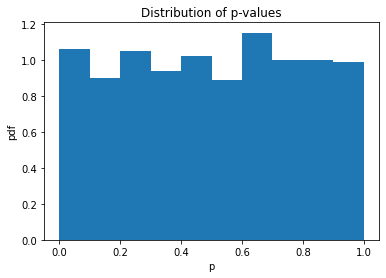

#### Dispersal Histograms:

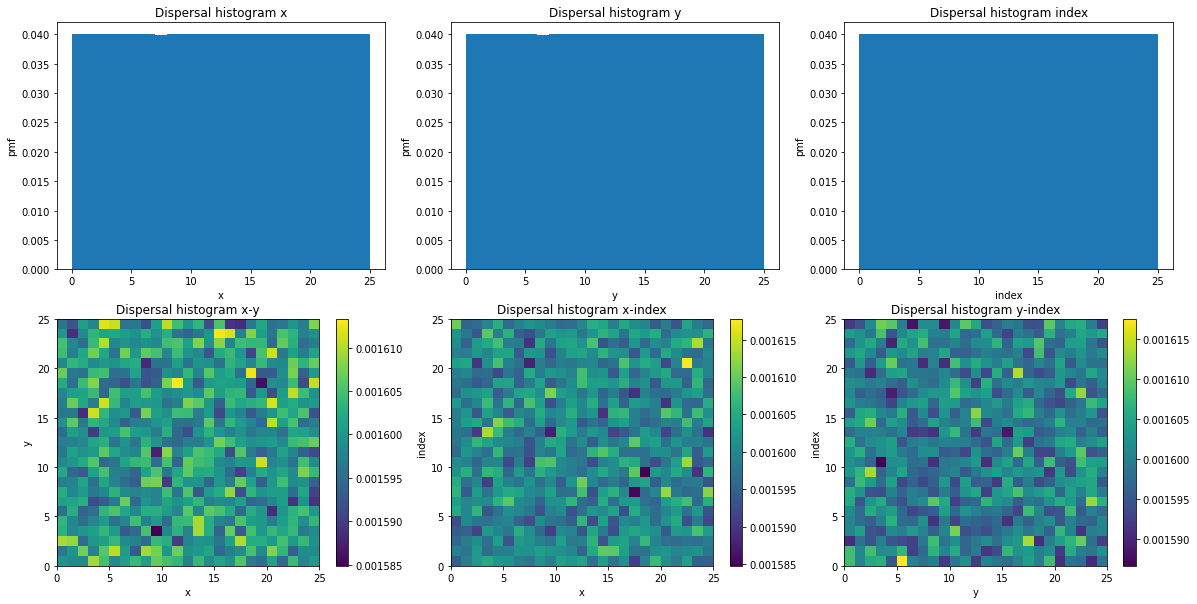

#### Parameters:
* seeds: [11282211421138106686  1533506146468130754  9279594814111972950
  3478607314697051188 15543394691595373605 15218437417949050974
 15575101927232574473 15972160668403575724  9005956642624374193
  6488835122674139733  5231206096153585111 10772043237171265771
 15931298932383040520 12896294294348290652 16518208409810197063
  9500271023720117952   257344515462279820  5046492835857107383
  2225699301731465736 17819603448267361890 10913228934871321205
  4466981778313849663  7012361125530671210 16476316262075076756
  5373420533030482474  2718827128912193565  5319112143615985798
  9644919281647629354 13698547187507844383  4554021899959502717
 14623307106205695034 13624274701862311345 11169702078847420286
  3641826431669964922 15879209626630176877 16341044321568508871
   785759956809532903  1858047847910270455  7540322608861019520
  5984522680505823796  6409166272995385667 12036150165062795812
  5480802824282805798  8785490842636319728  2250402910143670097
 15863805901438566215 14580879214948128821  4996912455925113974
 11488325988157158540  9864731598658280895 16183844963488391960
 17823045110741581802  7514124135718324744 12121253677059539626
  8449134525327205653  3884636612247349416 17621289517208213494
  4488190693827498892 15742471210439450048  1822863709596398619
  8749194010500091431 16149027768712473017 12978794422893080294
  5313699494894582278  5306421859689901930 10722816079758730497
  8384419968725517848 10989449124940597924  8657036852930320784
  9482360087635345305  6563859322249267532  7115096708867403890
  8964321794805595864  3847877006403741563  3037734211077182466
 10590375694598506191 13399725336153390470  4871824003264535776
  1194081578771480796  9364096153721114278 12385928748709367678
 14297990319171074542 16879287515009325433 15639748608187981110
  2824541619192883760      124957886696007 14627693376146574115
 14357764556194642934  2882917555426599114  4873166071359271672
  6747900932187669485 13540145880127228863 11530301078108864960
 18358587102054819686  5318106020634302474 12637319343823392271
  8226550955280980731 10236137344861216497 15899503793263220089
 14358527160964893526   756427891954203811   266593263485220579
  4240886222000716024 17328492011100618959  5928572694759951889
 13351971129097188543 10774212755720092267 10435764537110557708
 13594391109465368285 11190291308616602225  1388380327063380023
 10264515924216064957 12757792416663761614 11614840532538753276
 11904194919202010635 11308893614413537914   421151675328721425
 13723049379241286736 14606292105338043144 14466463135262903880
 13121400738930951189  7217471573345987883 17161085265613365496
 14307148438401240598 14877293296196370897  4268628750881493393
  9813262690963844140  9265161672524437898 11551004625657034269
 16274462893420467888   212759610991712999 15301641815671889189
 12453707144550871716 12151854154615696690 16748302047953475477
  1418676117804137865 16814711387927693402 10268482812470367195
 14893424755554668608  8329411245901905589  5610077864837097238
 15638389457638582832 18047281919506722145 12002930484256807263
  5622944256436674942  9361520683154669562  1633214663720897454
  8780832130269368472   962423370186840149  3179290437607182183
 14641096688193404514  4948124638595897936 14540403173912320159
  6474254033193646792  4982531887805431246 16198659622143142351
 17346119418579136421  4811398981524346414 10166897350859817615
 10409989407955556407 18361922928680910731  4632205444634908166
 12298398925187819375 16348174660744026442  7649696315756494088
 16957721385217413205 17162709729402036636 11671768558254836743
  8911970998432317133   977490020829307435  7242235892232397047
 15845687574039372380  6869886417710555044  2525994371074914506
  5493063673699701587  1232414130797094932  4760972163083908448
  8932120101859383411  1388035698754476549  5936532563369583155
 12384058039201294765  7460107357020826880 14355178281329603219
 16712200772475598943   191957992470215112 12742536467743951296
 17412441963185741528 11726197717781782455  8906122055333616878
 15448104824122346953 10180279462096097801 13237215242139178246
 11571540389996051068  8757969358659491530  9876841582242897639
 16803640494238629797  4230890641999770259  4336309835819781565
 10493774921811084727  8842533591061971149  9277821275896394559
  6737752233001447865   338414521402623809  7397739246337582799
  1593517366362281147 17613290799998180514  5260599253803820584
 11668816880797426404 17968722386594645889  7047574855391233186
 10417209271991011892  9033778857831921529 11574348294195974311
 16793605798695125747 14772358005581894593 16677679398032897831
 12809257036578576306 17101100716542958272 16581516539275147316
 13559090713981458464   386042235056928164 17962668508635499831
 18315516468790898060 12693965468996959941 13571873444851904138
  7990095996731457470  8086076661177377826  4279317326531735213
 14332197826599166116  6109955420436110922 15458586619163732350
  4678729343989667329   571588019019652854  6854972716829068733
   457847090795003101 10944826031458095914   565343386569338457
 17781571804210243634  8829666485809968202 11285456418997943038
  3158509067247845232  6265414943947571447  6958254038016228692
  5866784934453248403  5988619983357306375 12153337328829374271
  9844633859053969741 10729795093870136370 12300054286108002039
 11519175104783556658 13677662056538184708  2353132793219107209
 12121225445065095410  6607691199623100736  1866403975914765785
  4230745678625056300 15130527483254702936  5060013093159693210
 15588634573204197061  6339862097220158685 11498713774469451664
  9602346467943558766 11649142008595384067  2967934900261738007
 18128683668698735973 12745539228860723465 10638290106645564184
  2533409404918321392  5526852467690500752  5233857093862179228
  8519394318950637378  2938598943972434238  9061419577229176864
   434010301357224247 17576291823421116181 12599444327198064790
  6020517355123180120  3999363870828223227 16312525621603790886
 15173298429256072491 18433502742379127607 10194691054679784902
 12226624898100889899  4496861083436058869 14287700023640077747
  4168908058623258274 14185759678603940306 17363105182766962356
  3244222107084881475  7716171807180509004  8340171170500005445
 15593020218332832064 15388154497300494644   837718356395372525
 10532578027775113244  6011627697948011841  9032123715281250671
 18000022785339213613  2014482691024485725  8799776035623426387
  4283980339967933743 17847044663470650305  7998353549733471511
  2842006828609879060  4983723902812903727 10491954824012833258
  8346481802031915780  2412310216325186352 10526262582913724020
  4250957546688603735 14887207359213583144  4666324537746473614
  3836393991053638176 17438549783979008073  5872670840075616642
 11583413034593887884   777495927701004424   465072717802415707
  5366652603616546257  2599065058612328056  4085567201097298526
 17876051813593058354  5064443876278819368 17257217610654677042
  7419665369116209660  1147709255985747365  7346658684034731232
  9211735582830861125  2460352713006240030    45369324293721302
  7588932912603589940  1949922146504979245 14601336500142473922
 17062437589997948616 14788724865039708439 17580390902180320852
 11369727515515027284 12340249638151616403 15742058716047224273
 15677202575399877255 13073932399667449876  2909937004427090328
 16912582869333332335  4913984544937053473  5832553074051732375
  2328628939654711752  8083075956987272702  6042984403831647023
  6081658469435287532  4864611984116578776 18339681832012864679
  5041520215392281326  2289882379208686842 12530131608603155077
  2951704929256235801 17169738959699895201 17397535703118306969
  4822183095621061890 11839738851141410104  9915793957135890970
 16042567549143619408  4290035070293026278  5972324794770045762
  4338673927493905075 12278762113125437194  6219012583121133978
  7943603885912998999 12954659207191431076  5281909794415578116
 15380760139144790837 10586152962347816227  3950321302155149911
  3545189483685120569  6629287686061826338  2277883142011237316
 13449877443289795140   993875164793007188   870399295101898630
  9610803438662055236 12601535202880800401 16083296940470004611
  5026856716352421530 17644960556716628898 12232693830435201647
  2352543502510129508 10635630788544640491  2925354649944955973
  9532153510415415725 12042875396878243608 10806784766598322672
   467780993373250905  3189966708993919613 14161506021548115373
 14767137257404003695  5322774975890335954   561346606079816341
  7254795016094519281   548074253594041548   229361845653083962
 16165122412723689898  8159864742997755216 15031465074048626793
  3834158619380906764  1292825465641403908 16191559757451040268
  9194830748628404485  3298427589527551194  9436689488970797271
 10318699225104004821 13395897575976392631 13108484844859202787
 13128906218954563390 13139261794757900626 18066295630597771412
 18126734464316113147 13359663317942146905  5556195270010514032
  7896863400842792315  9675368194218560832  3797997541591310877
  6774994769139738779 13714409458246121263  5890078274543306073
   572340173238200215 17583312756334377569 13515771976260925493
 12647834302350635579 12746932106502224240 12953113130479982731
  9541799687109515051 17099583279778649715 10344277951598481101
 10665016449659301653 10420807916412560671 15803896408880104179
 15575512575527869832  5308119027554195561 11166654299840104627
 14710125521777335056 15253032176178847293  7133794140213626332
  5999495962268573787 11237832780321879051  2486409822199884940
  7665399282726450219  7712805752676339073 15441332435106197736
  7878018125358839799  1467770005995836939 12462589645987787675
 10286501851791681902  2920053595918056047  6046055329922432534
  4056287921047940086  1112508302578369762   268363038711500776
 15545352652601681917 12936515190778029573 15410292367803478427
 16542650198019089029  9998569463692870849  1555904566380797598
 16722181898407642295  3839409428997460508  4432126954349653736
  1647587296204955066  6019499758886911530  5337495280826061875
 12658386893500995784 18201363710095945002  6831129394705601052
   597489512604265652  8022272851863321789 14932524969136567570
 12838264644825889296  6938832155826166992 18381833482792759730
  9121346605434280899 11564724605051219221  2958922786672562814
 12091887781586824577 16290471950913973641  6326525293013634534
 18417873062873324045  6530097339689486235  3816569718373034656
  9980815658742244202 14598057427335876607 15629149125344593693
  9303646596846591954 14365190161784169661 14370860732443034563
 13181545758983009641 12288814376573258540  4032292885283902308
  9066689685839373346  7811270863936184370 11171176026162972900
 13459581100333230528  2810412910843289924  8583351478115547821
  7627318881633265851 10705121123714830863 12932558310964003653
  7618864705071458180 10297962710212243616  8013140609294594140
  5765385680424545713  6095744261391184363 18367759971472552566
  7879782288787701703 14803310596632220886  5519416034655106091
 17108399276698705664 14866769547331777259  4865004037452610877
  2654230342688965838 11814799523528708055  9828484464459857206
 11345303271116571680 16954640902125406459  8968302487784064231
   754471099127661182  3192487966255695813  8840377254183248821
 16152451350438732618  9423439587950202159 17660370676933809861
 18371764496912031392 11839134584228136609  3482609127543235327
 14692424373847096725 11979542500562274927 16048952843088914071
  4740867370474451545 14502466565613433727 11775640070578369508
  5498649088314634076  6614455496471428364 15010333006376480147
 15278159563698199784   801592930319149179 10252133777689225599
  7695079779319425225 14861455068108129556  6609331743747723853
  3453367155111509819 11191564886730102289  6033764104921874688
 17969618959965920850 14890282907271054359 13584898646515041775
 15758048727167614104  5490135511910084406  8162194324139771100
  5723547247010701589 10218692548390506913 15837213183161837823
  6702203450324593010  2607634455221094454 12692129682266723489
    93692958318579090 11348033879011444203  6053012582696590559
   128534284467916099 15847988038983766292 10820830011132237738
 12862019852796211188  6007192584071953688 12279388373501277210
 17870086891546989486 16073103397407721216 16345109778566253859
 10308826307490478146 12530904650553820308 10848487082293443350
  3787329251774031534  2156174603441693222 14355506884746648505
 15855265220605173931  2214069358677994260 16657618861332825646
 10720909274813689957 17900607309593147257 12275040862442233344
 10164033335408270757  2574876523414014089 17851447601132350137
  9999589389972045021  2784084416825275230  8420586390420672308
  4702336181185259623  8414685440344882217 12847466768712608488
 16618969285952685339  6654292815478893296 12301031774283720945
 16929343716787050325 13681223395277221718  8279894384830548403
  2165283190168967900   558821538017143805 12350464392196828320
 17566416593328069624 16417363726854630602  7893989869501385927
  9271674923666387545 10514779379862377747 17394310232667937884
  4900145187950244701 12209661894873712537 14017044364763900338
  2704250039959051773  4124303312803960406  5307545136127252058
 15204323798774204538  1941599785230029545 12572483847559636788
 17758368375430126966 11426680661821606401  3463471331916218604
 14475323895438452713 11499872744825945874 11354243056856654751
  7105757144945193581  1578982271167266511 10568894702182032732
  4469296471067023727 13932680388458198546   422078360287165770
 10771004317775266584  9451180840813452085  2222443872194759815
 11079154735438098801 10198954733925838699  7589855760421359042
  1833610909210133636 12715902676944868390   722329327164330008
  2092890077777949580 18280821827642272695 15763818396457039392
  4012295180699847120  8299064338399457481   554644532329025272
  3465405750830606725  8996930105313244657  8077568768454488661
 15594499719942901229 11761147787168652832  5369904480078089205
  8810738481317269387  2102273120745442452 10751692332226630872
 10344673918308345905  4939802927213160237  4016408915519179361
  6122790239958723131  6046287588410082309  4722087366080417257
 14047693012720611968  3852822985344091401 15676989066470538895
  1857675337326367638 15264469795552872459 10678085401900163954
 15791557981797999144 11050320904697079846 14896044744478273123
 13427173926116946826  7581010261627355850 10690202271826952982
  3815606772204739877 15694631897159234659  5273103967803447099
   655763536437940515  4441387513234528620  2304729280749646854
   936560827518076520  2163833127291069148  6516950964794400824
   128335294997275456   358370009331961950  6652388603867514967
 10553019142203718507 15457740291735372579   242815832082571413
  6793253707441795000 13361135134581949198 10097857155258380081
  4642611657085984683 13661280777828010661  1655492340988021181
 13078882853198298305  5390452959728390578 17792852557371095404
  8079388997918887557  5592797311892191079  2483123515259117807
 14559846664797198706 16162499960109812291  7626942652956226219
  5508400117083698073  6693887985655759707  8052132638924229573
 17968568317184136007  7997347081674526299   283749070810860847
  9302161840862911943 15062959235768049088 12492883013618851028
  1230265563318776321  9579966341348737476  2761636469617786262
 13611198022189223237 11808807749203970440 12902069290797099501
  1628609102390846357 16490068670368863297  4629429765684963343
  1749393564163467287 13539567714029684575  8514888545827996812
  4171236346939753615 17434541933748402777  7753110211736517942
 16737667152703421647  7373740995034528706 17234416031181361226
  8121675949476261779    97604755124482884   313219691328748688
  3073182445738816763  3265911061846197891  2821922192855314042
 15725506847830826606  5292175592380970511  8239974078021492147
  3742496646250238787 17048885183084536716  9740553349230884978
 10987043767208286973 14599925381420123457  9782915784931385185
 14217705665895998598  8080284404158090762 16384189446452764481
 10340646397108218671 13219934543447769066 13670950835399029783
   792740059262310510  2855864224423367183  8381425625486065853
 18289956610138000841    87764124317494612 17454836759603639984
 17142320974649094641  3053375084300642714   847406662284709354
 12284624155215005571 15493768185649544118 14991953064082673821
 16205673869480708704 18121274866018415058 16874833651280360798
   562440511733127634 11652807174377317397  5646238768185768476
  8343394345634710564 12083476164380450606  7215770251115200381
 11184872796306278949  2366112415656817837  2834092271477473860
  2324564901297287844  5469273831153019028  5296386364725288532
 15781264008369608986  5607513754064313999  4403626503709332288
 13864964286163166774   761732594292016107 10019768230713235713
 17916635349193397606 16756049600855393267  1606918861339751498
 17559466034653692154  8732041448575066040  8047227675063737640
  4818354872195046810  1964583025577242706  2930802770705116051
 14808083322861042775  3318055606684748657  8990021744946363793
 15516621827220774888  1559887866499134540  5605497924186439317
 15602715640789018180 14954045466257161799  1966776162097663349
 11762614219101151384  9236442755179277069  5150370856616224688
 11069646689742465931  1240616519324103353   852494457069728007
 16075847147650943649 13005120949171961183 11571738843718439145
  5194239939598422114 10529376726505645353  3273049932840695516
 12116372067230417291 11632325463840794274  7152566126932816845
 12279281739706349134  7710254227845117029 14440751975480414956
 12170365237916038402  3048030861115391067 11955622209005619571
 17917927496920788028 13375283819562320510 13516590128708123025
  4536272550983839913 13075841969967332712  8677708232195428158
 13922106540039111449 17104993771057617962 11707057115293897424
 18156701127137367997  7655094983871115644 11177821235575343578
 12797917642569179152  5270244265159138535  8926879522931951325
 15117552807529847377  1855740968716494653 13102515180815535946
  2110341121679881397  8843717353646112596 13195374091421603021
 17284397792639275028 16551332286970746427  3088828463483245149
 12136059708303033127 14324822946491612345 11847032577955389332
  8619125412275683550  7561256237416235977 15112393461100680393
 15933025963591209730 12238862703657081374 12795247808763855983
 16890461040419535501 17435855060125660728  3453418674115903446
  9386682865067085856 15722957113691444087 16495054688146658912
 16646636659494277720  5456106643085036200  3146495644150254246
 16098090323485609979  2630486813768607736  4835026245348162592
 10121671786344572072 13326454430986863446  2814705671642360865
 13214038102213722697  7119850415428642456  4870867790252666308
 18170855617086122745 10005697098913071923  7976630252501325266
  8077150336989834862   903817748004154717  6037776695731593327
  2377426851476229801  4316474873223963306 14854430484609304613
 14903717547866136364  4209463619932458589  8702086120684129682
  6404604551781635326  7447248021801963334   326191808850886275
 16477921677587826163  5399626606214971876 16297722341443250360
 14819114898232466421   261011890975573038 10666375364751882522
  7713900385826790495  7481306141486918807  5212695182597103386
  7938178219984071486  4983664088462220031 17310637566871945747
  1686265877597616639  7440144386308381869  1477497430635467499
  2248932120082056431  5709192788608871071 10399471815861452128
  3448458579211839964  3749462015500049850  7392456165198890621
  9544720570223806623 13976286019423650886  3876222216553842205
 15139761693331025112 17665522007573469998 16254545914646172256
   813765163980279238  2901580832614365791 10710242158917648392
  4237966485225311856  1499434487199758910  6294849154277827034
  6925159082280617180 18348061636321139620   234601901780576859
 13114189520794759159  3751411206396644359 16169199342733226350
 12801723029721094179 18119275340900535598  2655127036549207624
 14645149062517196464  7699921777331439315  3572629819528400275
  8736195293786985166  2367152128126746671  5903994846060069477
  1681251447951596110 15170588425390658488  4374096213575200887
  9893065950789619427  2391910084343636794  1366281394599912696
 12771895175763767424 13587002482758236890  5820038973059570417
 17987831264518291863 11176905477931483990  5214315681536083867
  8571842220190972470 15827324180174440335  4823094761048457815
  2543467469621086527  8126136478290032413  5065442032824413392
 18330918874031015450 11163855910930675169  6499713039060983962
 12894351964300603365  8379472711867268079 13222526425309225544
 16247292247713602097  4483100280641076100  7118076267600887214
  8553593844262819027  5840191963061483724  7660732749275346674
 10647120370996702888 10538831423896559697  7828344040320953088
 16999039980060011524  5346750947646286203  1623912611190435950
  2624897648807601387 12576632620735716302   895481336104031951
  7514001309258559603 15084034844577350551  1344989954440656958
  9207694740577501741 10502590641191658462 10354833275434530916
  3614432130328865661  6015988729828539910 11986310018152406043
 16328416985340097118  2128978591365263256  6541751442298280695
 11984236010733930575  4778148949294860873  4451307161203003089
  2689158306098654157 11796665398296851793  8406385362842110979
    17752356929769152 11654065128635103658 17016442298190313996
 16847832755210667724 15411766321810183117 11985636486419256719
  4476998306257877258]

#### Configuration:
```rust
(speciation:0.0001,seed:4476998306257877258,sample:0.01,algorithm:Gillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|██████████| 1000/1000 [25:07<00:00,  1.51s/it]


## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.6792138107357729
* statistic: 1970.0424790255224

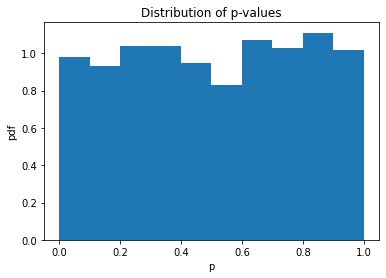

#### Dispersal Histograms:

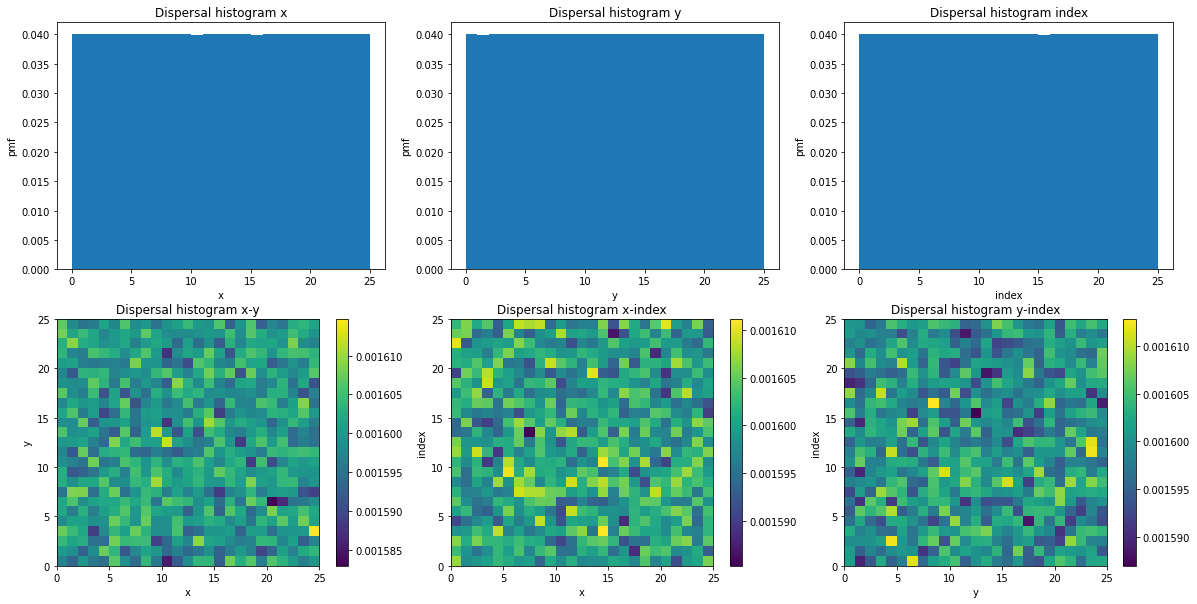

#### Parameters:
* seeds: [14613226978574639057 14924197893601535162 10229595153996687733
  5468503695979794032  5805708327051767086 16469896060391007849
 14666029699251885666  1490948900606231680  1355269264227832346
  5848068101724987588 16988902561580067741 16609579144932946433
  1613397759399175220 15321721892090369981 10657999053437657169
 16704100834566432406 15202112982833751211  1147945529796281184
 17252061913057492728  9834588418658825714 10088593577828374044
  3537163536565279064 17004618429099938010 13379780764331044108
 17464049178893446727  6628361731365007381  9848494496711655151
 15641561649289971617  6825685057194633615 12011927581192345735
 10426778706370189574 11240658478516989413  1452614313621687798
  6766605572340841158   412862667001642121  7397688586911665657
  4250684848625281933  8980367396271253087    28896764512321544
 13995774035971846137 16056607005686740014 13786827981273728661
 14202023689040989352  5208374017410039997 16484996032111754139
   579930240054706996 14891089146240068445  4706007008480569130
 17632657716249624861    82520959665894623  7385326637951718329
  5469850497977766996  8697311074146921327  2026385380436782599
  5623166035068747553  2109533468351566740 18203961188722436725
   250260659261434005 17503832296422513980   907139754357772039
 15216151781667347676 10554394474722447986 10581892651571811784
  1625499387267261922  6697675248599292779  3925683393117987856
   217342615611924132  8559953474315086755  5452020161179039632
  7392424123473095529 17733363734031223061 11153100961923594130
  4706302765708776180  2974462147670043482 10171788190957337028
 16152485952413272882  2371972513359399416   230588253748334498
  7187453509263442691 16005410557558206346   940163688370025407
  9285015356868152994  7116198577451096208  4235347479088831670
  3591531188717947392 13269355011914040642   519835232981102479
 15257395021953738905  2868657809610365607 16333828417077521632
  7259069346018971793  6152527681873638609  2629715093965301978
  3951689775506105198  1219596514925640235 10564034317547648985
  8853138653567515834    95183795829573236 17025103236595435880
 11095289057725851895  2067889831825150623  5336236766238393584
 12807604910352929001 11622298273127234599  1754159147029558523
  5590344566938861705 12918624754087876437  1027388307261856159
 10685367077852523963 10130383662297180537  4541315154756291080
   166683934621367836 12752738274809588630 11878268474553597941
  3658455340530696252 12485603277657204947  3543467963820923406
  1393568121964254086   490581884219471517  8082864679410667282
  2014407778221671209 17484072721997386348  6896351506537619969
  9462863116486348575  5011726103619027007 14599461388968869339
  4241746794197083269 16164990928713686811 11693995859866265474
 13584773165812111535 13383113945301739141  3981312292149233629
  3507231142421542757   366699266893724674  4776819005045454382
 13539946840898245511 13552571756562067801  2393470548835316496
  9022804003098348783 11516564625887901629 10956328892186864448
  8282440490336562829 17815212468840389829 16339832910134731272
 10965774405990982099 14623310322231539306 11669620514733073777
  5634796538626181433  3570819895065764293 16560865408849659199
  1527396909026150329 12063761018896144556  7292160098482754137
  9615792859460165384  2505645449771632593 11000098044675129768
 13711226228071547545 17672405332804140825  8786544113942256732
 16702560571207562876  2934586176412709332  9427280182352118977
  1390669420042289492 16837840051127972362  7359261608443996983
  1014593644444782827 11337511508067467263  2430761826408035652
  4960531524223291077 18064606402071645604  3319109664193881867
    18222292441663943   752821257819880705  2352567917481509638
  3727614883016431774 16936917779012810288  2227450745613086515
 13631509143640568147 15933535008458723987 12265099833853886430
  7737005608521436277  1126302267066450986  2112905019743772935
  8122017147977397156 13897491979451399097  6817051027889616915
 15346349026261645496 16383988100488684414 12839233327578328943
   525626637784027583 17263360418229557638 14878919949160411376
 13220528737817355372  8936562543450787763  4801626283935901019
  3079296978864985361   124438045846376906 17733248910371143255
  8259994435612616705  1215273680589750619 15310375776387262891
 15154853570259574076  3737449265768959178  6285419565047400395
  7196233037287175470 16827739225342654680 17401072573314226178
 14185740827312819861  8083584284381528261  6772823783842460132
  2396556613384640465  2791096203773083265 16702891595090174388
 12598879535282819705 17915330986791142047  6542045095118751692
  4891945202880235126 10958228767011238067 14158207907566429035
 14863657237532529732  7923451786226595125 15850993458175208572
  9186190317639706394  4644980082500499089 18318704147391844274
 18066245682298466117  1932084414406587613 10048235729125007884
 17072642013445458697 11809909876303189204  7532218170893616180
  7592258943843903515  1510427061563809991 11069351326175488730
 14576673144240872011 12577381936078217940 13568149387720934631
 17545442679721757850  3177290623421419316  9575635209052995655
  7437441300445870488  2386679970571434706 10992879882668136306
   119375039021558629 15131350611998501624  8971858873690106362
  8404633751311963451  4900326454188504336 12930709674312098667
  7770657515523118322  4631670729473489176 12558005908789381611
  6809310638854206012  4405859895150781536 15650608975881224772
 11755167096164909073 14692484556917434203 17479505601205153826
   197253568567431178 14797102229435213959 14590191962959991969
  2085051557514968299  3785570244874997784 16044674218820198360
 12674259371025062774  1976660415151433751  4348044532520301523
  6080740766050473950  4281647046364512113 11122349354311964334
 15370073902287825521  1755539579485865024  5173923345373458960
 14756727345961721132 16716085851183849672  5314814437964929040
  4019463105424092984  8783513713329959155 14301394888402576272
 17081930746470460823  6707992034369430419 17526875484846193149
  7629130797357401936  9303505795657797598 11602420632021194649
 11510334785715776570 13814883955949067699  5867564403011739477
 11133155874921408283 13556195730519781948  3401161231713125613
 14019021398091498149  8594474715049892758   697561579124995902
 12873021743136329473  4420241299300314600  3162019627265927660
 12268996515756331100 16025320657746021913 18138577699683434457
  4434133019479907297  3493326063841825578 17440305387412669074
 15776225152955374859  8036542759689741872 10430268198267308792
 10212020402620001926 10813743586013809547  9583217973495803237
 12426569035085937001 11079858691615022910  7780005655018549479
 16334652152461542043  7484764680247617056  5393680904354182667
  8680852325784153446 17535123490180680561 15551106884348205652
  8346227390366933595 15834467722039869878 17370593121007788638
 16720358988459283598  7792269463370128624  9229177913400432579
  4893836426177452924 14094712570033509238  2170316681932286619
 13458475365397435719  4766356658007738619 11221644236669506766
  8515604602257088841  7154233921269180908 11176747602299012995
 13719253113390735123 13684399845152006189 13380541023273435161
 16865427603512143303  5599346164814260418  2364227981239408178
  7832032623194313385  8213598449429223398   305883229675994955
  9489175723363921223  4512512498118733530 12007255190738618698
 10949651690445856718 17579289198819100750 10399664915706059430
 10805564229816402674  8142320643201590273  4439167533557841689
  3744768094231373329 11553790212497619260 17699629318881596669
 12449110846547086198  2430705874932009415 17201772659184656463
  5133597341229001909  7000622791173605438 16056643059309536409
  1643066096485525574  3842184670277988173  4232056811193088195
 18010220726230223885  7366679147084307744  9424725763962975144
 10739381149480758287   598023593266198203  2765863875857620396
 13725857327042214759  2759517042298417815  3643072749383503317
  4343493329972813491   518093451311555218 11564156031619576905
 14337931732886605586  1362904515984301450 12831008338853193222
 13212939800406935996 16690675300383043523 16647933048534997266
  4430185246456662004  3257578911839109474 13268711971097076429
  9777240635321405178 12704702473848958088 14155392462500643382
   159779132693987830 10399150183745409389  1664146614336638396
 10635475485664961731  5989125573129530505  5667659264152222935
  8581573952181614256  7774948875039779741   127440312763947933
  6268953617878569657  8119770912360341498 15044249293699553079
 12148135512813898427  2400021032750393963  7219342140971172375
 14678912051319634489  4192829910178664144   230649777241243156
  8344999603132418797 13277107978930677130 11133782941869973997
 13015029360962408125 10981841636200720557 11444512934065153191
  4571833089628265906  4766954308066324941  4933825927359104433
  7017372225059007088  2250688113514210341  8249385029519315565
 14356950125442065682  8944068047801848664 11133715732766522860
  4906247735336979007 11455051149571845989 11889563475979141690
  4771779521171913449  7261216273875227889 16978379894621312031
  3961893231054194638 13114122550189683258  6987145792808214115
 15577539266695190501 14475921560938825518  4409516409909743286
  8672533967750353877 17794280856040504699 13879693510368321172
  5005820932065490982 14505043643137028341  2683021537774571203
  3685192019358772024 18107678916471118893  5614545645725979280
  9798967575892868385  1559078106288103570  2655021162385418944
  8963424953491619403 12615586037676837043  8816803760793397454
  9691116099150972024  5805485282649073742  7723119877376974307
  1114435207623747867  5292423150878045099 15166067029523445665
  7249068352874238430  8738606765664979227 16675052928713944898
 17387567683634410849 10638112698289805422 11525156036328600145
 17439437243417118506 14605567593628958050  8291448232277693846
  1423736241773914817 15676025569768825071   656283182859128424
  2901309124130366991  7820556224123734381 15135586007374639122
 15651454739729693180  8358698131667582616  1643384706683888323
  3166495670495349543  2840418579583724469   474044960023041256
  6606961607988880164 13841208559055391624  2940548151264654501
  8391475906069232952  1007043039919590235  3548193631128865511
 17422874503667137331  2551938587001408053  4474499200028445636
  3305577836157443936  5018607013250130734 18421216625119926216
  4752868190447578836  6826710285321486960  1612877654897852116
  6390638464220446288  3028763855542244337 17904860308128449593
  2839343934154978808  5219076472675712737  1402741989338791439
  4673782610863276877 13228728163790444089  2370387483550793895
 17234697379482433055  6701783093653289927 18359525605253884879
 11451510937315873599  1234284679927160537 15944058096642502101
  6901884154118367582 15880385847671087703 13052474406789649752
  3054377253671051600 12352397586380511976  2316436120747102189
 15463495734331500789 15990544890310119580 11156800492256948086
 16982327796020248679 13690629045231389440 13119238634426973285
 15709949326884489445 15763653807151753188 12206629519138111363
  4419195698515986814  9575295702101969964  4376226338320551727
 14094583429818704329 10124954403043758021 10006325437786504742
  2012617349249981312 15307691212067384265  7418241099499023196
  3663905772748342116   910108609956829448 12584681957450245849
  2354421243434918824  8582386247563687336  1685303246340639995
 10406949941715239562  7714612982112636937  7178036151263695811
  8233795227168554489 11096262685886732094  4751263506543185797
  2108707488750961998 13131540646641815134  7617577926013058589
  2770015462835034827  4328830602476093594 14807265890363328230
  1061156684819698237  6956830545442278660 17438599963743121778
  4437603408559355446  2740687129164207919 11287409881593422310
  3678512206363740563 12211638864117728235  4105472126303615817
 16933964526830353329  7568988281309836907 17223557842374303276
  8412982830943995045  7083382959229936698 14204345586638836974
  8440108039052655337  5065239238747636815  1639468624017197309
   550720413429243580  3905186047537234381  9100652308601288953
 11205730034497605703  9996624052548718788  8455152723587501541
  5293563376133516406 12912334691613154791  4342423980528535124
 18161182433246479694  7062398901325679901   290657380842284510
 14111374773676788728  2012805034113751728 12867724163272287096
 14166895250744468456 10163027511250078850  4839513398261783727
 17746595791490059541 12885373518243551234  5698807802748709444
  2393773912753747027 15247121847217911572  3567613345949014074
  1525869071007873653  8341513671429056543 14758412707024528679
  2076236705754100103  1195220659538475362  1077136409986442102
  4080576853126326947  6167433659197581348  9983935249574970461
  6964619726613551708 14128054276175263823  4541440002985810635
  3074828506433999904  9494360913516445686  6660154677203536015
  3062078129937210572   325463857442510207  2796938760243647537
 15971265922671526042 10599649745995384034 12073627134569400946
  2715330777587329000 13326592128384174786  1779292860226600501
  1723919127417873275  4017705807133381208   436271996471829370
  8903717984605061055   671035633569510956  2875554475266210246
 10829174577701000268  8012644990786764665 14328454910703029762
 17748660105732181628  5297811368636828103 16811245236960939456
  6170395033299013908 15780288173341008841  2008308867988092854
  7770283994902234871  4320276939788940291  2229285022556793394
  8545310732200692006 11028089149315351947 18425769487254211706
 10057092016068203942  5715845619857227799 16644120323616528326
  3473830341321152273  8762527196837505602  4315945703185150073
  4520885746083898463 18234668333580937103  3663992474497106749
 17558542151862671367 15131226413136401294 12826264908573282468
  2664033736526818790  7878963961074983130  8478241498356421289
 12437582101851050983 18055584937789997424  1356351093992616762
  6296583994228979814 18251650364154618130  2046170731702311440
 11824089971478298533  1242894838293576359 10717928330487665004
  4200761112974396147 17653307580607526803 15083163655934990145
 10405156005303925669  3989497210342418213 17276791414296707055
  6362483458559859241  8771594715860361607 17331466923944506659
 14391270186613628103 13008973493280648020 16919799828363516541
 10195482968689911331 16401049890489185824  4582860280759474152
 15378404408883842765  3435595472679346429  8018833986301073933
 11685308478064475135 10163698474761199401  4832111231686919002
 15815434518904295107 14427702185513674430 12281008766067457679
  5128711562366330553  9177701596539344361   701250766850709694
 15950587478938593971  6391580202158489299  6871607897970353228
  4402807357214900947 11990115340044458055  2480259874334386560
    10514632081678887  5938799342601419392 12901537074015226279
 11137515694683427477 17601360336949461370  7616236694738316915
  1146750376654034596 16940182639706130697 14521241026945061475
  6425543406659330984 18087045479787717418  1965921601878785273
  1741705658545691683   276811646634025939 15399414500278862997
  7160257758954018953 11213084352083954983  6497115948242323157
  7854771732725517682  7251680170755312160   120786929178714618
 10588648787013647439 11567991790343840043 12391077970500438273
  4176132963981303868 17544862079267685838 13502837959015129212
 10394192779963002631  8958799260398991060 10154183448689274504
  6312266313570579949   119924364718985687 16890735398220795712
  5730470247960343791  3488464596958563725  1589202330179853967
 13910007008826008854   577880771815243652  6201990731287111607
  3843363359186784390  1019881078677762622  1517850934326367167
 11035782692437143764 10190820634320674594 12530768435590637531
  3160994087465990555 17951928289476990132  1652523296070063431
 11240838484783994829 15462995507545676290 15094493872144358470
  3439326949659217681  4822794966891809631  6158452790660290612
  3939298848466397595  3518854622204232570 10557685198085412915
  1033426291467622607  5921623130184084128  5836834571763753409
 13135509807149179254 16827282821344190175  8423836665530210949
 16309157524709243747  6546105462897291650 15036090981851219525
  4218462349810365051 14780950576202784020  3280002900262777964
 10318783671892971810 10445759996518279980 13296282804425190850
  2879722938276933590  7285133121209058328 16212811652491641959
  9982119726282238117  3608388802496699388  2873276659862343796
  9697894961144720490 12789544418287030974 12032211675341254088
  6649640857225500802 14640055848116990719   924856078563248108
 10343574089743619555 18090800164899146059  3497190654000409638
  4699815402281665239   151377214174917933 17588680494359497768
  8222094317585365138 10196401296919433084  9853277061119608378
  6044777948000459272  7551602253677034292  6625013460635321838
 14816874182752608204 14968133320618092087  2418191416361453781
 11321927711830692655 16727952194479565433   988152871387950969
 10772888745343810335  3124574321069031222  6338003132028216690
 17773835825905650976 12965610802671357688  7149706214309547599
 17774471319651119495 14745374158409372401 17875932588212127362
  6626482421588706660 17640715036027222195 16603768860368137142
 17524381756331472627   456864457674964680 10862729127202905914
 15855194860061203630  6680439680281929438  2125126549724447365
  6697021815358091505   258152314224177486  8937871498051537519
  8878705713846105300 17139916146343506081  8624747281284475836
  8953442275078835943  6298200693892854434 15584146809226222791
 16024696390478815782   814890153947601974  3007595194681023269
 12922437836973021430  8660275504852069690  1660746975484727567
 16548184535760954816  7577578440626275258 12026306106847893399
 13041631272297919983 11186838622504600078  8840707910432540914
  4135120948499998530 18431881513294769973  4284035207399891636
  3792183464508522128 11236274870602803670 17527779263572971726
  4209992092667680426  5688820966319728931  7116953291925427605
 13598542332788286299 16351667712695286902  6790232064187398296
  4885504231253117701  1217671582647798623  6561359271085476021
 15633994102395460296 16591515156216824923 13712794239820788243
  6122669731514075945  7828806457613614090  7597264410404634752
  7419736315650264220  5959631443639062060 12269259061046624201
 13455804844336743068 17193679396336496072  5052108210391703140
  3358260220290948668  6570461759935365772 14657069070912011442
  9327909691342902650 11860373949977920592 16710301255336750528
  4279509889405837770 13658813428590055921 17902813727452187421
  8684622341109300979   987080858768400837 17464104533030315414
  4326570167296040001 16265534260154124628  6553575501437024399
 14304818180019906410 11687829966723542999 11647730794687382857
 10744993382002948735   411635700564119106  9690100502147963523
 15543586257157893376  5203918911889867191  2440843771948055479
   895330402268028055 10252318112680996191 17660811063192394644
  6671957372335982440 10306972350556399431 11805707860548716805
 15847776826870890442  1105925747908685460 12151247135876002634
 13611583077110392710  2553460803140627953  9679102045509692236
  3523419876686878184   567409173883900652  6402242920482095813
  1953788241341313319 15493222964782622573  7456036685247239723
  5180384268852128807 12768012150216046588   747711928171052745
  1321030983118776798 13422585362717795418 15990080757458459077
 10264287098850554207 11247290650642036470 17737788068527604058
  8710160093714580549 10120460090376903697 13215239678315509948
 18251409687384255919 17160889654661234361 11346652883836022683
  8121012954434670905 14016967846428757935 16536619802049680138
 12117224138818804947  9063624773113551444  4226802750212202295
 15260882690179368752  6329749285537245902  6501091722432418255
  9644577665611120572 10183010809276049136 17041969276431072425
  1380925119786866821  7313702355923743578 16704531776059480181
  7438081906399097032  8786384812098415575 16092246379530971396
 13321233948714113909   863912922155073069  2986387075798422119
  7166965805455385336  9314559523641393529  5047120168230854963
 16401351954371399727 17995989097147827495 18063594541804754489
  6557792206742402541  8073755666860150552 13381659415805791199
  7331356022410207936  9277379273268862465 17079288349841775165
  7995680584649149337 11907400614060755410 10268087085695810687
  1752440208304834954 14742775085659547198  9155681232306107583
  8681582037865702107  7105566326759325752  6862335471467769858
   970660870198582039 11328481856683445593  7027057157853063020
 12707448562280569939  5681174352777982141 16347593716894216489
  6071645826469840372  4553917231420175424  5762364081270165337
 16682992976670698786 14325947837042271419  2069768723699154486
  6277408660142996353  4652536255948776480  3612213046132371474
 16376222744711706693 14963181602834905866 13637329776613765032
 18198949127487291771  2910450422588719876 17424962075475981523
  6481314962500996064  5043572947842958884  5389384487835209995
  8580328337802939289   926682931656272591  4324368740375876754
  3974094114991115473 16752348246281790132 10232513938249445059
  2380602944203140960  4006313370255687501   529581899137647483
  3878306334525747117  7967246360602757248 11149667384243610048
  6938888608428354213  7617138581608808954  8378498985372372690
 12656799166145109838 16824413204486210487 17016657425417149557
 18115861833923256835]

#### Configuration:
```rust
(speciation:0.0001,seed:18115861833923256835,sample:0.01,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

100%|██████████| 1000/1000 [17:42<00:00,  1.06s/it]


## <span style='color:green'>Independent</span>

#### Fisher’s combined Chi-squared test:

* p-value: 0.5514016540659947
* statistic: 1991.1745451559261

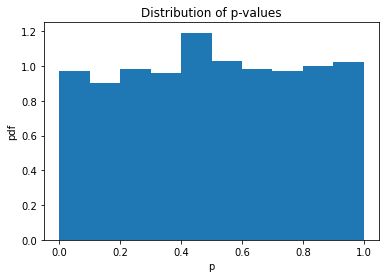

#### Dispersal Histograms:

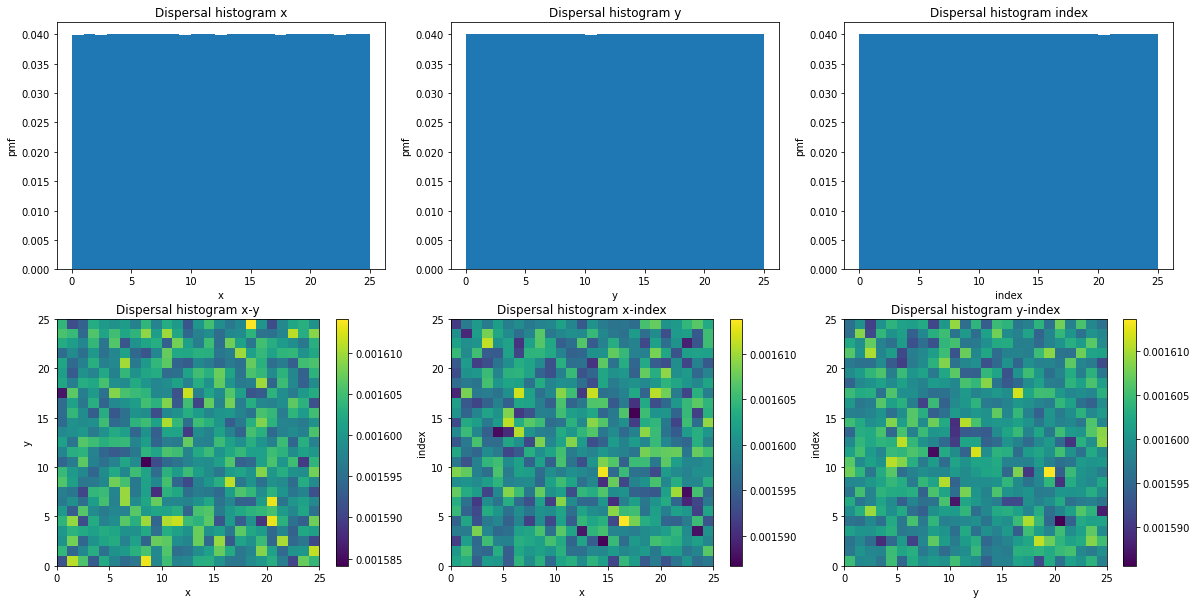

#### Parameters:
* seeds: [ 6996553305139123948  3232408033216060685 15636199085375851146
 11026348816347109214  3460898431704802253 12182447059395671404
  6566127548537438734 14120108895882821240 10637681113198678103
 16360956770494908639 13186567641523821012 13421182520123461559
 12401212629507538160  6196544298097813754 13354956045136011359
  7779921728141360401  8046535461945865489  5754184388551698222
  2224001894880970826 10936236471528340650 15077996379965900190
  6856926121513554120  5189730001372772846 15628952309555751338
 15579608145996044998  9692358856791054538  7565496180983666970
  4686042226430711396 11187303527717089736 16758739560819864912
 15358929024050516321 14554421989546678769 11879782920567427321
 12764437019334631789  8663058548874956372 10222182735708869834
 13471282659132464807 17179697333812866721  1311007813340651527
  7967111535564308028 13061929330096910936   556029191541199620
 10923064347888353452  8820049401912782100  5075233047302362990
  6224943199037422869  1126250928270338993 13282150814459331774
  4522896661072860901  7760130665449330733  9692233201020938746
 16908635601344085016   656179430382842381 14695070844166496724
 15245939229421406755  4105606943889381535  1057636696017576610
 10380458141115293172 13021695655412073675 11832402140269374802
 18240637193602560697 18242712322311094443  2361504317525796113
  7222332639853380005  9687725552809539460  3105131844540351634
  5588842752758875363  2754380746015228757  3548631312284556378
   876858916498983317  1670182814906564548 14535687118354644905
 16120011756470658098 13743163049975862190  5948571422901040144
  8903614436580127688 12663163817507459771  4821073977460579130
 17603509308370974530 11483197770207153713  2609791054801934807
 11923861050481085153  5942639306630365187  7458889011751977453
 17684175884786980280 17737516143422528517 16372992114704164700
  4317227289373114727  9395640639762549760 16037764343215613310
  5858417053388970384   143412760698791577  7636750514107759560
   309887677757356893  4591305306385267662 17133634504671135325
  5497358969004921222 13139482959037898703   356519218456294722
 17383458832534102745  9436321955451082801 14210819377205007098
   859352999855657260 13042744965652428141 11918870952418456542
  3013160909811972416  9279388400362752835  7923861991695642258
 13416474809855150652  9820054880385841029  6994347127678412221
 18187312253682187599    94394071050924629  6905372189924565775
  4242192369231393180  4077221226488679791 11866312502606363473
  4746345924185093328  9956254584303715183 17299084004580846843
  2649234040139967705 15766671909478196579 14892643860648933259
 16765540548098942971 11119485594287060191 15904658596991931073
  4092252483607844390 13972638109263624159  1393773419620236004
  9431856271188220642  9522181551812502621  4250728835840975166
 18148621136126830754 11577560264956634619  8368369707854267103
 13768183683026136406 12803188905064805679  3887315587567180529
  1126151853101165795   805235843860908091  9519910265325605592
 11358532855279228519 17313195592926596372 14342311000970313512
 11157166675082534360 15326620934551617495  9126257392570670572
  2135119265690092021  6009682324472179388 12378089914479577164
 17890559360295105930 13599470017761638448 13997836450891302912
  9691780404700974467  2882272163346917831 16494477095767360179
  5290137362744287213 13593811101895398196 14019638756396833486
 15390235651696018178  5471169291100586771 15938489063095834446
  4095854214944961152 10627983024143713939 15065035371038720713
  1748022268452100381 11084368002030064969 15998290015234767554
  1873794464193160176  9008692096505284916 11484430282897778082
 12187068119039849375 13106455049248016790  1971687686277324918
 10400978327091724547 17160486133630755059 15151886057110748187
  4663981229293738719 17204447394338272827    14353355158488654
 14578568837993130427   616023791353043278  3411990644674845971
 13364354540116119342  1731117991698036780  9694916344775343497
  3447574727053846266  5086670868207424395 17890796328907008093
 13982067865280363154     2095355994162874 15305394859333241296
 14656965263682590939 12435244037751960924  3717484362188991418
 17489220034399559680  2943106561584377181  2612604275710140671
   191192117803789553  6453744575852801114  5345678297882265535
 11267732037860671274  2420741564530492012   169784853102916846
 10260795407225818675 14465578498540267729 14831937066011064033
  9155457282020530978 17618517090102643773  4535924753638771099
  2649619784671660976 17274994032429834661  9237471524388375251
 15220594418969643609  7508558544930969154  7624266540767731783
 13004349354068737038  6832108377745656658 18289725122368160038
  2668578494973547651  1885500248733009997 17029729765812394729
  2347487029898467480   995354978827214372 16094860022340597346
  6459441935404416064  2334739720564508455  7138520587756446112
 15820021087184839456  2917984862086524300 12135687250851737148
  7575126191080399560  5142937133666001190  1436990624815585292
 16299990906522106694 14822084417980331062  8908714354409919676
 13026495479610908677  6609582855605097741 18301591603180480093
 11111841906683413573  3113485356107467313 11098707393519570642
 10286803692603740444 15542047216134882915 13362379607463866282
 17352579419929557568 17126184333400157106  5461264712227907731
 16737507107077072229 15724534795799624011 16699292438995642825
 14967545116747578232 15563939387926116796 11428982647750942793
  2979451745631495319  5116390439767046266  8155032348944324125
  1440862234083611864  9522378011928116781  1373994437841296316
  6931603433022215368  5871858726366514015 13792200756755585098
  9923767429308797641  8949704939173577326 17663487009090320651
  8283217027037854448  7136762107556751870 18338011546515827587
  7778832724707771724 13774866152302207347  4209009817978679282
  5613623205237360624  3447995349851393417 11711902001883180408
 16143639869914413537 18197519365400494093 11715802964938117633
 12356649505811596729  7110409980300584274  6637479101459018515
 10610662567495189291 10849504264222368557 17470210642117228559
  3455725793418894170  6277460133862193794 12446601786092883802
 17600773456965712823  2577580757226030690  3976178574028401566
  4028767425289463802  9112630418692617690 14840313543307117189
  1834999264280285038  3256050320599465174  2550543001766531755
  4153804282550055118 13566967828318245805  2703296166808124994
 11183858912852967528 15342180407031008794  8998960156208818622
  3326294208256665073  9766052686233682691 11580756730602105739
  1595600947163391871 12734784766796772182 16479686571545131717
  1573524419521629813  1591724658285217714 12966427878777433977
    96907033196456782  6032490703672449176  6042614726807568753
 16264078441119874848   371332134888740529  9680993533126869535
  4259296758828141665 11890507355909574248 13896262188984360881
  1180147068075817113  7491251687388034098 11614562012459461586
 16284755180780528489 14521235658873355486  3601978506242941004
 13314744518995391834  1935919996135681043  5441871793383734036
 11799987658897867820 10751183856142740152  2076086890593838454
  2389773200620384809  4858872762686030904 11289498476267409705
   571838469373810497  8567005651053725966 15868421804790473497
  1756743042602649356  4130006576505718707  2299658043057151936
  9407506498052460189  7398667024919544488 16365183823284870290
 18040438861086503714 11467599356593444367 10778853069150801568
  2807285425867132785 16311505446224801271 10618621593501447709
  4867932469283676573 11272009521518144678   240592855980996212
 14054199523370530122  9073135660294728228   881257040674287849
 15808935971737747509 17509758064743138892 16327834811379451904
 13794797127165272120  3077689849268020346  7643163438983243396
 12682216836131524517  6671696939649600476  7683882106889985495
  8912559405002240207  5876345561582080775 16840102629598224014
 16494016068848313832   755180505429495527  4528428971848989266
 17352980567467339301 11828464534843564867 17718268732889199808
 10332272414038479402  6544859369380887102 11270057243931888622
  2570572487340866108  3415917716475582937 13822056096000109805
  3274965398017957474 11301459733122633418  8590796245967950378
  4909894996716817296  1503220347114383874 15505510239371814640
  8512146332688289523  8699875162187863469  1028604584194466000
 12355641161565721195 12371286032935667770 12097788565422487410
 16117623552051726155  5042539092364284985  4543964717853276246
 17872258025520471334 11761507410140378007 12155903699294199794
   250504453710443268   146725307508784035  8758573724454008367
  2925110049775290605 11570589297804536657 16273508921788897051
  7222420639999429820 12092468064495399521  4128166157571589140
   758283032134352959  8003563721940110177 16420312184067445495
 11184213365131656386 16778928511361154661 17944209115381628916
 17381682062120243828  7462602247887961828 13279415451761355961
 12463094647936604042 13986700021853505902   602976211041252275
 14504470023765183340  7422872151048564378 15593126042224884819
   634473105473893615  8725368020018445566  8731998844652258169
 10652207266215909839 14072155658835269091  7832158266812952649
  2901358432403641042  6318650976445067315  5741291748463900846
 16979608206440484389  5056966254104105832 16211132135987477567
 10998480811935921344 12466918927444868137 14030959916479807481
  9116733076201440465 12035097830050740552   266758722544093676
  9317660507160767253  1566901156367371857 10161360896078362938
   382976875420471276  5642440790944158365  8572176317147561497
  7722876823484816105 16235811250177355488   423927150222052658
  6730184598733340205  8044649873581280500  2638671189191416859
 18108541766069353056   461885475073830615  7816331372442970584
 11952346884548876407 11264250679980798835  9115716298078937919
  1517549003600010654 10357195042572306233  1221932667108244583
  3528071755043591914  9412908339496556169  8963992384691308666
  6672659083646399220  7588709007897527757 13435286755391389107
  7986773923382418077 11544431804809395143  7083423184469554947
 16450698289616258027  2722150772081075672 16387408911267721720
  2962584416840713479  2504224051795565941  4100837297388944656
 10316654923674419230   591673674332533786 13791420715634427243
  3574929281483901455 15507455169633519411 18208513835245604474
  7470995993116166268 11907674437205162331  9022983139372434474
  5515736732434097311 15051372879980126328 13526231601500475094
 17164980906960014274 16243589993528019070 14572377938691463669
 18404571654984393754  9673192104890875562 15587569390212397274
  9825394278177245419  5267771740779704891  1707875291144780009
  1669671398508247531  5675391311871535435  3790148686393165367
  1605926955298135569  2158359913488950734 13398614608092072019
 11120212557547416244 12877480933574071449 12026095551262984268
  5061802498339492215 11890427590603997404 10423540249830771765
 16129056351605707586 12708888316728929862 15687029001110023028
 16930744582381371631  2020951448251863212 18178549993116405611
 15053846222642911722  7650026003037585111  2471970359638334075
 12864368241851120672  9251233355927297131 16152493165603473762
 13956628917571144523 15441967405390152056  9470339547770128912
 18428946549383006303 12346826700352994586  6783414258699609491
   647218527625262693  9606961479186017404  8008559740609377464
   521814567581195383 12454811568337491522 18201944870143549345
  7198120067525296640   433029311349594270 16586138859300225985
  4363353722237965592 10657120373187347782  1065031592851234149
 16234551412537988860 16797031120649080301  2318687871707266804
  3808640841216337652  8019577314279813837 14471759017518606251
  8623070348021243553 17381611341670731201  6263912273599825009
  6106961003988891184  1650725474750600998  4295940518165360054
 13569713641996808473 17744527794057212349  1124054145731322571
 15486799205320886317  4002324384828516693 10856668310981674088
  1032514862479325123  5331120043405538396 12784635719678102472
  7751755782996176082 10846036617140486765  3665493411439870388
 16401841046083062807  5135424463718676716  1049422310567677834
  2637906265101217248  5635081839956340078 12381547061186863390
  2490909059415285557 12309839623772843835  1001294741735820262
  3609994798615974366  4064752903908563933  2332187203025258474
  5938849020717978716 15294293527727623989 17525162288356945214
 11705425365043871852 17140967658658250781 14078517855942799837
 13482270893337409271  3413834241900943928  9482174853637545989
  8807145390816172291  4788976318985582151  2074999103147267378
  9434851518751468991  5932510098651517332 17727220126418645679
 14141891165376500729  2913153227214498904 14785032422553517745
 14068190565840667398  3216120297779688377 17627154806436696744
  9017858639369267891 15553460702956409752  7806397196131230245
  2411928682900771287  4283165810346032236  4435199780793177181
  6608800863787573257 14912154492784324603  6525948686497387607
  1192992602323662550  4782618958682325000  4206526556394270036
 17567308705807920004  1396361064220826650  3099313270982137074
 13967324432319388702 17319024669939369250 13339829698823151881
  2597468818656927545 12785105228450234716 14348032205055118321
  1472005394848793965  5605062734882316307 12055029922629829876
 17846385252157102675 11435010640527456985  5482583398674322169
 13099134093219528823 17290759326638772563  1756448363408887859
   607270172698753616 12680008872403969352  4666986885206797144
  5569660141656448265   324123742664228523  1496400666471516480
 18219907265883607144   477540957177362309 12418578069566414240
 16467371884779210106  1973441745722226819  2235435895568520818
   856068838466743490 14409577055184712541  7569233653277937369
 10099699722846093780 15630480537223991949 17341224018923805036
 11705571742616980447  6271190205077086143   284555567555525338
 15806403372661148446  5356571482458035993 17616657534887405677
  5823009207291777665  4357750810258463165  8186318847293121515
  8727576883396289408 13174665695949399717  1870170963670407332
 15484687329452915203  8291322479161786216  9505999312513866805
  7266851918151264127 13257722391382045528 16195463890477083626
  9306886582709371218 17213951660218839060  3832737640085051127
  2117798506889706057 17326452907453337975  5230387650748223192
 12717446679214322396  4609266147567600286 12507489466380854688
  6446849486852390214 15991996806969114260  9378722666363661910
 14038321171999509910 10646693193868446075 11151344580906696616
  2578484307226422180  5060979090788214994  9836740500437247347
  4895538181214806575 15982945757167655316 10542847171827677145
 14430004226152789116 15875697150800131980  4526081363361166447
 14288801844373765680 10138228591904942420  1875490047301100051
  8247313368997296704 11256889799282287440  2750650559453051046
  2631433962736997125 14198563524989401407 15469288450524845163
  7858867901688221859  6965999256231462116  5933011451252765417
  3027754649985217643  4130675187492624830  5197276443413805438
 11836537751108657209  7108900364130056663 17956369542057469329
  5528612619314827331  9970161462689761044 13696756078744805450
  6825465306605461553 13639514022812710332   564065388166524045
  1182381798027149639 14551927452313548325  2626587365566772053
 12321515251440339948 11609949200413577478  5499203061236072439
  7515750939552454018 12772151424691303764 12434051284684080726
   953656181233947802   460810638783556253  3315409800754531895
  5080783051295965609  7593808529655785165  3766368625237668865
 11256160183076420048  6763937697084006140  9992751134251773839
  7925029455323474090  6221253530910198975  2456277941008383971
  5368728716716026790 15319388758297127967 11612911255876833714
 18319832866139037192  4714566290742696156  6050542329163972061
   517771486648055037 11172638451061617812  7056280248108736924
 12715214554237138794  4124288587202661744 11561158038282374123
  7295005216229228220 15008608964906558607  4896852097033710293
 13091175517783487578 17800908487331553924  6775860061042503608
 14915388347784268487 17528605088094069898 12540396934245580130
  6305731676828989070  4448558382679830835  5161015694781462417
 10285349939946308163 15741468744416091118 10587389276870497901
 17300967139010080223  9762229576714087950 14788367556682217231
 13970500268327817529  2505623741790425922   350799099697447685
  8159604940701487013     7915174926617470  7879839232710246455
  8633326643459914471 10324898026313731469  1221909520729523934
  5630694789464126469  5944711910671380133 13174575518991981877
 18092126118759999574 13336997930151975891  5697359069623084724
 18206871378312075582  3644858139588252584    56994754755182537
  8972282572512390859 14269202609196179038 11677817675639572911
  4472367422476638099 17136764037398609168 17961712408410496428
  8371394372518446164  3106960842578000593 10167988767606143616
  2087496368326485299 11805509386010640481  5934664942371164921
  8383785828391207790 10929409355740974327 15538296149610432125
  8821302214082181094 16396596706210902325 10706302595833444190
 18243103385104081012  2882258327762638392 11643870339431129161
   135235985699118377  6052255689149038563  9877288613391447129
 12165223665506184953 15386138927616546798  8459800980333851906
  4762848352385498661  2274886351374776689 13793948734587371634
   786722199479848640  8904441201245517250  5428399563411388289
  9519128351831271666  2753000931084919298  1558308154855172313
 16593108524379599254  9624873141691204884  7695004996587112534
 15759136109107730330  5357522383719458983  9320776515019013008
 17857338686527583666  1908602322980925992  2994217731428549182
 15403841711267740506 12803603354830598982 17761611284468971601
  4642031537254105217 12723619777579078854 17424487620055323694
  8866749494802452319  7318954686289070474  2183505914374445779
  1140217610615875033 10868142621016545060 17202933952171879719
  9178804535149810952 16360720293109952108  9976759103569604493
  5816151153098602169 10629015951270874743  3208504904343906614
 10774788843944366537  4509074082129891902  3562458603421701232
 16134506999665091045 16442038618671789939 11956268897815428909
 13754741173306833062 16826692839146693355 17600686278015054771
  4137918012321733942  2380254792032906848 13686791187337884368
 14714725499870104633  7073030259343776607 13091147332483758590
 15010524963615592075  7322811466234014753 17400798602329218780
 15268221119215200791 17679772518063348162 18191236631799018520
    73349757775980483  9771156376405543184  4342419242045832868
 18027216723462962959  8604378862476087427 17003601494971734473
  9114293736357316791  6436653106969831434 13762203123801682073
  6098740473803798305  1834381643113570197  3440339326782073816
  6446201562984265977 10991668534197956448  3915662979910163940
 10890883757113929841 11140447010976721729 10911607719049610019
   242349369791308933 13928885745655484134 16097617801262586972
 13228632858710112813 14600918940863564217  5190216618993912025
  6787820189692869360  3327633386495663085  4083405542057434633
 11947778865622574983 14545528101094782221  6170668330802101896
  6781258171622163941 13313054936772835254  7586650576934047225
  7212464136362205223  1583711966568996141 13367271750253666119
  5073561495325991969  3237854772006119397 12652327330636595508
  1403021643459991316  9230014090385557089  2578070525965884880
 16256058015174268113  1827696493303825772  8006965823126620429
  2682307368317131317 11233019517412443634 12098723629704691348
  9292641962217726083  1899491160016207381 11805770561538382673
  9119693246063950480  1221273520599071087  4469343096003197194
  1993150387857136120   114652811433319559  8534784615739763921
 12902884111526836367  6756531301497860066 16100858835673115172
 11585470377300228115  4052855173342236833 14933195652963685769
  7745195231971189941  6580319156087868214 15742737515982506958
  3661895684506936766  5907177902081954512  7432640738479612538
 15099596459778688780  3413806066686457715   863914453928004290
  2101357652617577584 16870532664027226182  4961489938101591575
 12642120332842055476 17955809956954918551 17516685778369365736
  1816377194699941897 16986164968849125992  1003593010656244320
   987972442966593783  7636111740747060287  9673375082095120736
  6373589019501518515  9834641212407950268  3968329087233872232
  2282086786429243072 11791247678201238456  8364447212225450869
 10129866767050721367  1196102583213251634 18367200272635683708
  5578635358213685865 15095098613168437985 16508170129312006496
  3733214255373723212  1351942394174305329 15008766694196906255
  2440517033356855248  6395676982634459394 10012025784052060307
   762799987579218496  6943313211112723577 16522226324002280131
  5338983773576250536  4541631800970914091 13946146758274159122
  6303175180985828006 17270408770251068934 15387947151868312832
 11594047564990131009 17168953384420603023 15643253213282052498
 17081888592818895531 11016961408576442101 12856282598539858226
 15156813256589032698  7652549600406198239 17206787518791732888
 12076534601353247349    88846600034530571  6264019205005560806
  8355341126916367883 16488707298994967235 14920243852935066423
  1854209431749615836 10604272759885147083  1080257595815426998
 11350204677235720654  6801664749038160645 14469947827332958391
 10457774946818375980  5265871505694968936  1850870757562494896
  9145839061588578365]

#### Configuration:
```rust
(speciation:0.0001,seed:9145839061588578365,sample:0.01,algorithm:Independent(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_nonspatial_dispersal_coverage(
        algorithm, size=25, seeds=seeds, sample=0.01, speciation=0.0001
    )